# Classification results rendered

Displays all plots and metrics generated in the metrics and visualization stages

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import pandas as pd
import numpy as np
import json
import yaml
from pathlib import Path
from IPython.display import Image
import matplotlib.pyplot as plt

from src import paths

In [83]:

params_path: Path = paths.config_dir("params.yaml")
fault_detection_dir: Path = paths.data_processed_dir("fault_detection")
metrics_dir: Path = paths.reports_dir("metrics")
plots_dir: Path = paths.reports_dir("figures")

with open(params_path, "r") as file:
    params = yaml.safe_load(file)

# Parameters
selected_band: str = params["selected_band"]
selected_score: str = params["parameter_study_max_metric_prefix"]

# Optimal plots

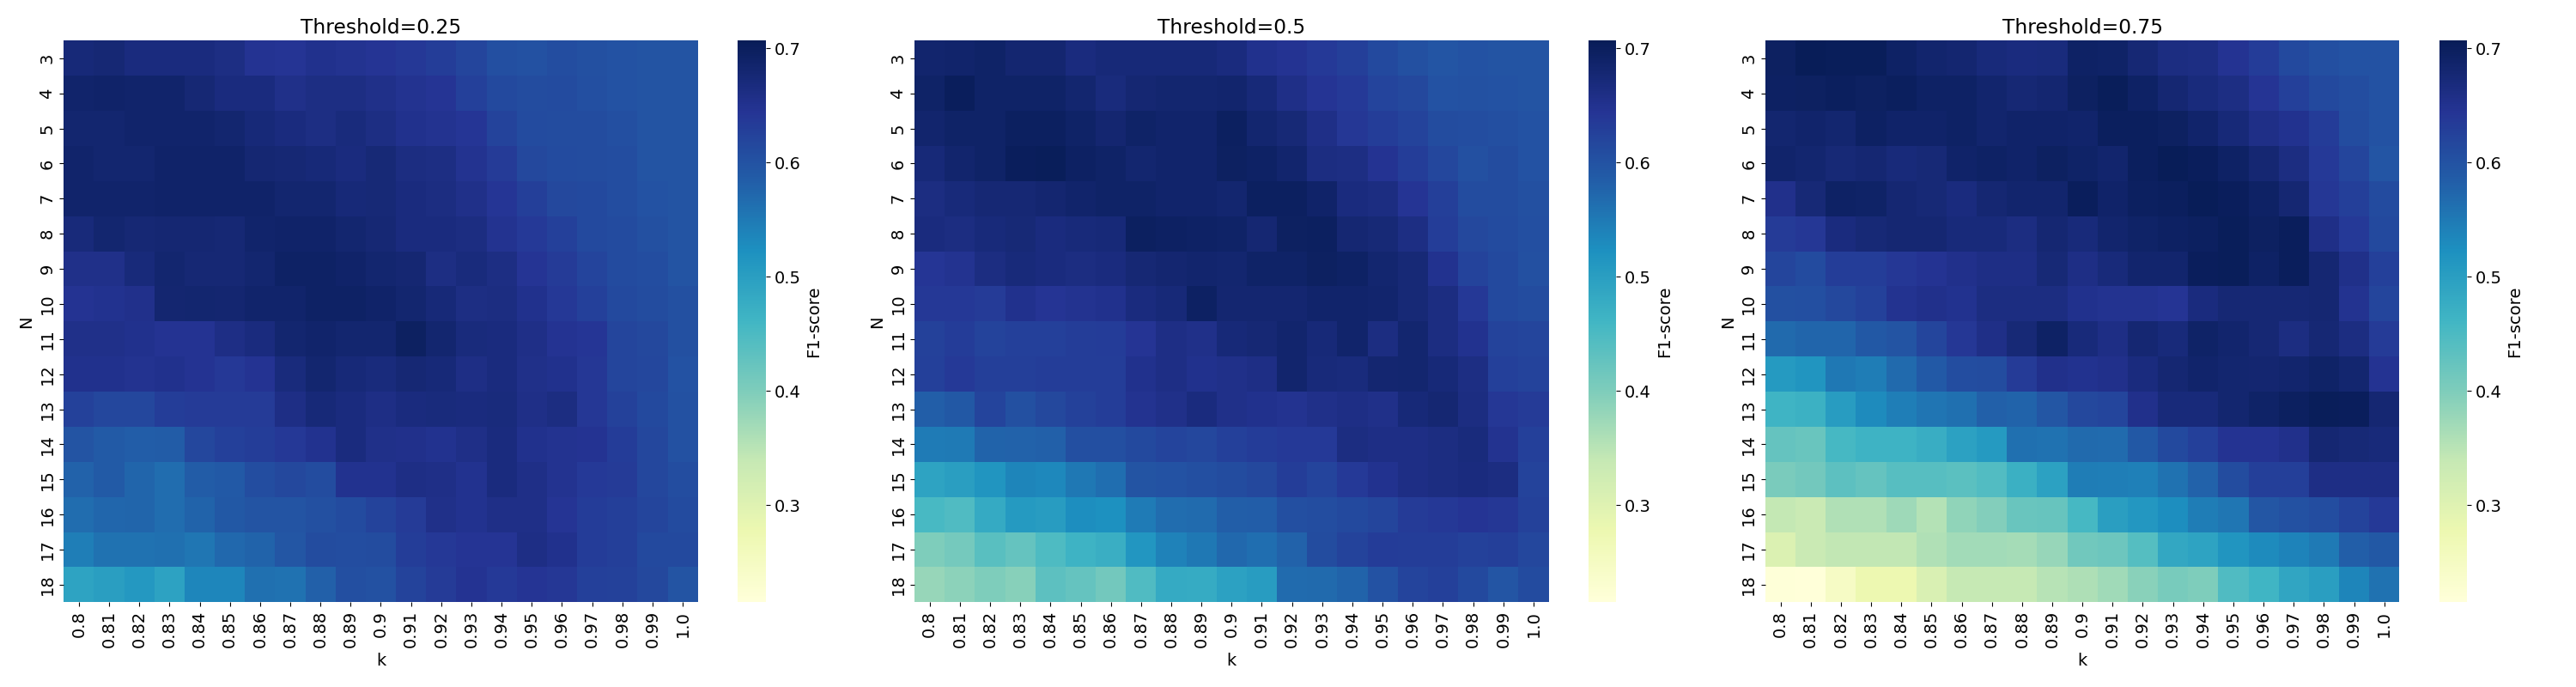

In [84]:
scores_over_params_plot_filename = "_".join(
    [selected_band, selected_score, "over_params"])
scores_over_params_plot_filename += ".png"
scores_over_params_plot_path = plots_dir / scores_over_params_plot_filename

Image(scores_over_params_plot_path)

In [85]:
optimal_model_params_filename = "_".join(
    ["max",
     selected_score,
     "params",
     selected_band])
optimal_model_params_filename += ".json"
optimal_model_params_path = metrics_dir / optimal_model_params_filename

with open(optimal_model_params_path, "r") as file:
    optimal_model_params = json.load(file)

optimal_model_params

{'th': 0.75, 'N': 3, 'k': 0.81}

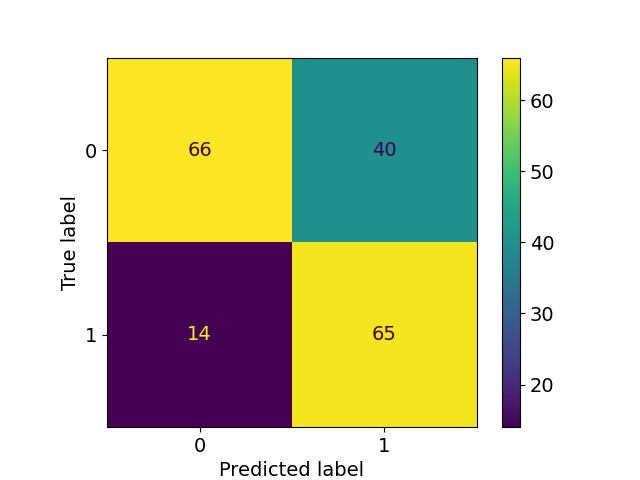

In [86]:
cm_display_filename = "_".join(
    ["max",
     selected_score,
     "cm",
     selected_band])

cm_display_filename += ".png"

cm_display_path = plots_dir / cm_display_filename

Image(cm_display_path)

In [87]:
classification_report_filename = "_".join(
    ["max",
     selected_score,
     "classification_report",
     selected_band]
)
classification_report_filename += ".csv"
classification_report_path = metrics_dir / classification_report_filename
report_df = pd.read_csv(classification_report_path)

report_df

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.825000,0.622642,0.709677,106.000000
1,1,0.619048,0.822785,0.706522,79.000000
2,accuracy,0.708108,0.708108,0.708108,0.708108
3,macro avg,0.722024,0.722713,0.708100,185.000000
4,weighted avg,0.737053,0.708108,0.708330,185.000000


In [88]:
detailed_cm_percentages_filename = "_".join(
    ["max",
     selected_score,
     "detailed_per_cm", selected_band,
     ]
)

detailed_cm_percentages_filename += ".csv"
detailed_cm_percentages_path = metrics_dir / detailed_cm_percentages_filename
detailed_cm_precentages = pd.read_csv(detailed_cm_percentages_path)

detailed_cm_precentages

,change_type,label,prediction,proportion
0,logging,1,1.0,0.248649
1,stable,0,0.0,0.227027
2,drought,0,1.0,0.210811
3,drought,0,0.0,0.129730
4,fire,1,1.0,0.102703
5,fire,1,0.0,0.043243
6,logging,1,0.0,0.032432
7,stable,0,1.0,0.005405


In [89]:
detailed_cm_abosolutes_filename = "_".join(
    ["max",
     selected_score,
     "detailed_abs_cm", selected_band,
     ]
)
detailed_cm_abosolutes_filename += ".csv"
detailed_cm_abosolutes_path = metrics_dir / detailed_cm_abosolutes_filename
detailed_cm_abosolutes = pd.read_csv(detailed_cm_abosolutes_path)

detailed_cm_abosolutes

,change_type,label,prediction,count
0,logging,1,1.0,46
1,stable,0,0.0,42
2,drought,0,1.0,39
3,drought,0,0.0,24
4,fire,1,1.0,19
5,fire,1,0.0,8
6,logging,1,0.0,6
7,stable,0,1.0,1


In [90]:
non_change_to_detection_filename = "_".join(
    ["max",
     selected_score,
     "non_change_to_detection",
     selected_band]
)

non_change_to_detection_filename += ".csv"
non_change_to_detection_path = metrics_dir / non_change_to_detection_filename

time_deltas_non_change_to_detection = pd.read_csv(
    non_change_to_detection_path, index_col="ID")["0"]

time_deltas_non_change_to_detection = pd.to_timedelta(
    time_deltas_non_change_to_detection)

In [91]:
detection_to_change_start_filename = "_".join(
    ["max",
     selected_score,
     "detection_to_change_start",
     selected_band]
)
detection_to_change_start_filename += ".csv"
detection_to_change_start_path = metrics_dir / detection_to_change_start_filename

time_deltas_detenction_to_change_start = pd.read_csv(
    detection_to_change_start_path, index_col="ID")

time_deltas_detenction_to_change_start["0"] = pd.to_timedelta(
    time_deltas_detenction_to_change_start["0"])

In [92]:
time_deltas_detenction_to_change_start.describe()

,0
count,65
mean,-43 days +03:41:32.307692308
std,90 days 13:26:17.971049593
min,-307 days +00:00:00
25%,-72 days +00:00:00
50%,1 days 00:00:00
75%,19 days 00:00:00
max,26 days 00:00:00


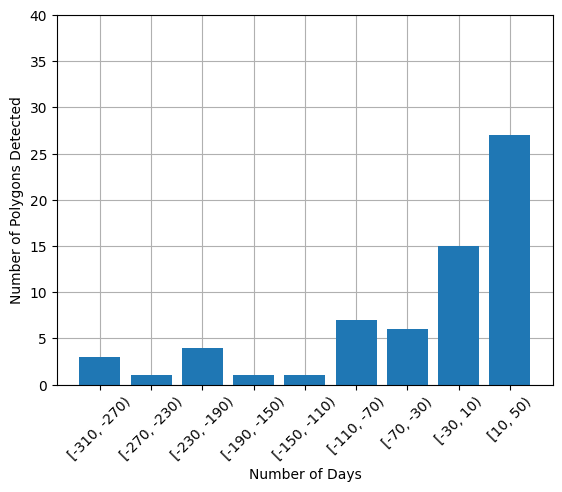

In [93]:
global_min_diff = round(
    time_deltas_detenction_to_change_start.min().dt.days.iloc[0], -1)
global_max_diff = round(
    time_deltas_detenction_to_change_start.max().dt.days.iloc[0], -1)

plot_data = time_deltas_detenction_to_change_start['0'].dt.days

bins = list(n for n in range(global_min_diff, global_max_diff + 40, 40))

counts, bins_edges = pd.cut(
    plot_data,
    bins=bins,
    include_lowest=True,
    right=False,
    retbins=True)
counts = counts.value_counts().sort_index()

# Plotting
plt.grid(True)
plt.bar(counts.index.astype(str), counts.values, zorder=2)
plt.ylabel('Number of Polygons Detected')
plt.xlabel('Number of Days')
plt.xticks(rotation=45)
plt.ylim(0, 40)

plt.show()

In [94]:
counts.sum()

65

In [95]:
# MAE of detection dates

np.sum(np.abs(time_deltas_detenction_to_change_start["0"].to_numpy())).astype(
    'timedelta64[D]') / time_deltas_detenction_to_change_start.shape[0]

numpy.timedelta64(60,'D')

In [96]:
false_positives_detection_dates_filename = "_".join(
    ["max",
     selected_score,
     "false_positives_detection_dates",
     selected_band]
)
false_positives_detection_dates_filename += ".csv"
false_positives_detection_dates_path = metrics_dir / \
    false_positives_detection_dates_filename

false_positives_detection_dates_description = pd.read_csv(
    false_positives_detection_dates_path, index_col=0)

In [97]:
false_positives_detection_dates_description

,event_date
count,40
mean,2022-09-30 18:36:00
min,2022-02-27 00:00:00
25%,2022-08-21 00:00:00
50%,2022-10-12 12:00:00
75%,2022-12-04 00:00:00
max,2022-12-11 00:00:00


# Plots by event type

In [108]:
non_change_type = "stable"  # stable drought
change_type = "fire"  # logging fire

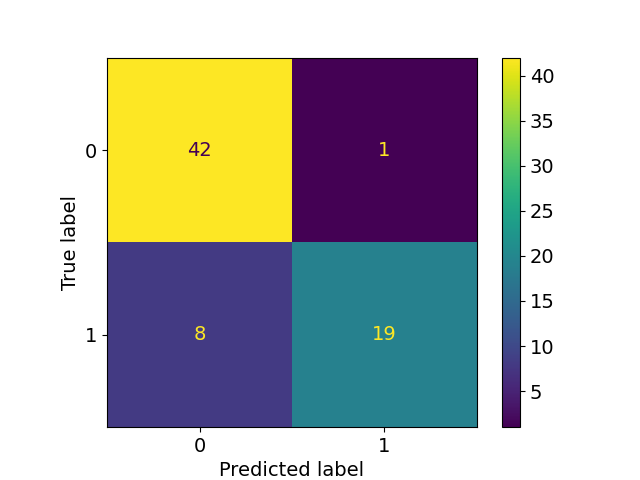

In [109]:
cm_display_filename = "_".join([
    "max",
    selected_score,
    "cm",
    selected_band,
    non_change_type,
    change_type
])

cm_display_filename += ".png"

cm_display_path = plots_dir / cm_display_filename

Image(cm_display_path)

In [110]:


classification_report_filename = "_".join([
    "max",
    selected_score,
    "classification_report",
    selected_band,
    non_change_type,
    change_type
])
classification_report_filename += ".csv"
classification_report_path = metrics_dir / classification_report_filename
report_df = pd.read_csv(classification_report_path)

report_df

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.840000,0.976744,0.903226,43.000000
1,1,0.950000,0.703704,0.808511,27.000000
2,accuracy,0.871429,0.871429,0.871429,0.871429
3,macro avg,0.895000,0.840224,0.855868,70.000000
4,weighted avg,0.882429,0.871429,0.866693,70.000000


In [111]:
detection_to_change_start_filename = "_".join(
    ["max",
     selected_score,
     "detection_to_change_start",
     selected_band,
     non_change_type,
     change_type]
)
detection_to_change_start_filename += ".csv"
detection_to_change_start_path = metrics_dir / detection_to_change_start_filename

time_deltas_detenction_to_change_start = pd.read_csv(
    detection_to_change_start_path, index_col="ID")

time_deltas_detenction_to_change_start["0"] = pd.to_timedelta(
    time_deltas_detenction_to_change_start["0"])

In [112]:
time_deltas_detenction_to_change_start.shape

(19, 1)

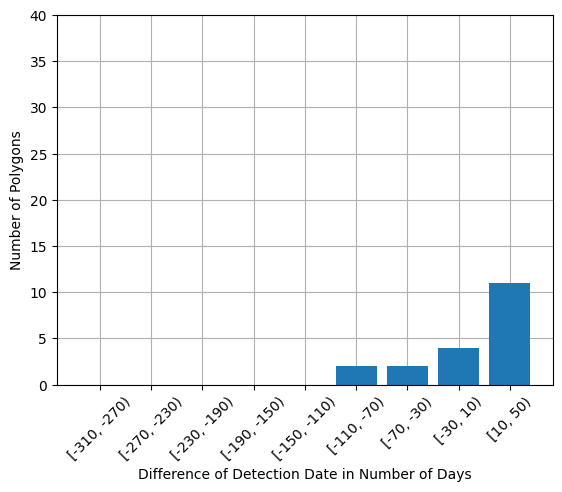

In [113]:
plot_data = time_deltas_detenction_to_change_start['0'].dt.days

bins = list(n for n in range(global_min_diff, global_max_diff + 40, 40))

counts, bins_edges = pd.cut(
    plot_data,
    bins=bins,
    include_lowest=True,
    right=False,
    retbins=True)
counts = counts.value_counts().sort_index()

# Plotting
plt.grid(True)
plt.bar(counts.index.astype(str), counts.values, zorder=2)
plt.ylabel('Number of Polygons')
plt.xlabel('Difference of Detection Date in Number of Days')
plt.xticks(rotation=45)

plt.ylim(0, 40)

plt.show()

In [104]:
time_deltas_detenction_to_change_start.describe()

,0
count,46
mean,-59 days +03:07:49.565217391
std,100 days 16:14:29.844208735
min,-307 days +00:00:00
25%,-103 days +12:00:00
50%,-8 days +00:00:00
75%,17 days 18:00:00
max,25 days 00:00:00


In [105]:
# MAE of detection dates

np.sum(np.abs(time_deltas_detenction_to_change_start.to_numpy())).astype(
    'timedelta64[D]') / time_deltas_detenction_to_change_start.shape[0]

numpy.timedelta64(72,'D')

In [106]:

false_positives_detection_dates_filename = "_".join(
    ["max",
        selected_score,
        "false_positives_detection_dates",
        selected_band,
        non_change_type,
        change_type]
)
false_positives_detection_dates_filename += ".csv"
false_positives_detection_dates_path = metrics_dir / \
    false_positives_detection_dates_filename

false_positives_detection_dates_description = pd.read_csv(
    false_positives_detection_dates_path, index_col=0)

In [107]:
false_positives_detection_dates_description

,event_date
count,1
mean,2022-06-12 00:00:00
min,2022-06-12 00:00:00
25%,2022-06-12 00:00:00
50%,2022-06-12 00:00:00
75%,2022-06-12 00:00:00
max,2022-06-12 00:00:00
